<a href="https://colab.research.google.com/github/yoooniverse/NLP/blob/main/CharRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

입출력의 단위 : character-level

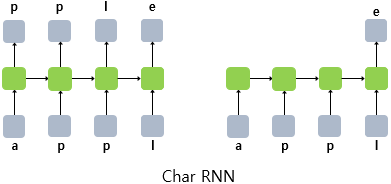

단어 벡터 단위의 접근이 아니기 때문에 embedding layer 사용하지 않음

1. 다 대 다 구조의 RNN

In [2]:
# 1) data preprocessing
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")

f = open('11-0.txt', 'rb')
sentences = []
for sentence in f:
  sentence = sentence.strip()
  sentence = sentence.lower()
  sentence = sentence.decode('ascii', 'ignore')
  if len(sentence) > 0:
    sentences.append(sentence)

f.close()

In [3]:
sentences[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

In [4]:
total_data = ' '.join(sentences)
print('length of string(or number of letters) : %d' %len(total_data))

length of string(or number of letters) : 159484


In [5]:
print(total_data[:200])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with


In [6]:
char_vocab = sorted(list(set(total_data)))
vocab_size = len(char_vocab)
print('문자 집합의 크기 : {}'.format(vocab_size))

문자 집합의 크기 : 56


In [7]:
char_to_index = dict((char, index) for index, char in enumerate(char_vocab))
print('문자 집합 :', char_to_index)

문자 집합 : {' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [8]:
index_to_char = {}
for key, value in char_to_index.items():
  index_to_char[value] = key

In [9]:
# 훈련 데이터 구성의 예: appl (입력 시퀀스) -> pple (예측해야하는 시퀀스)
train_X = 'appl'
train_y = 'pple'

데이터를 만드는 방법: 문장 샘플의 길이를 정하고, 해당 길이만큼 문자열 전체를 등분하는 것

In [10]:
seq_length = 60

n_samples = int(np.floor((len(total_data) - 1) / seq_length))
print('number of samples : {}'.format(n_samples))

number of samples : 2658


In [11]:
train_X = []
train_y = []

for i in range(n_samples):
  X_sample = total_data[i * seq_length: (i+1) * seq_length]

  X_encoded = [char_to_index[c] for c in X_sample]
  train_X.append(X_encoded)

  y_sample = total_data[i * seq_length + 1: (i+1) * seq_length + 1]
  y_encoded = [char_to_index[c] for c in y_sample]
  train_y.append(y_encoded)

In [12]:
print('X data, first sample : ', train_X[0])
print('y data, first sample : ', train_y[0])
print('-'*50)
print('X data, first sample decoding : ', [index_to_char[c] for c in train_X[0]])
print('y data, first sample decoding : ', [index_to_char[c] for c in train_y[0]])


X data, first sample :  [49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30]
y data, first sample :  [37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]
--------------------------------------------------
X data, first sample decoding :  ['t', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'o', 'f', ' ', 'a', 'l', 'i', 'c', 'e', 's', ' ', 'a', 'd', 'v', 'e', 'n', 't', 'u', 'r', 'e', 's', ' ', 'i', 'n', ' ', 'w', 'o', 'n', 'd', 'e', 'r', 'l', 'a']
y data, first sample decoding :  ['h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't

In [13]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

print('train_X shape : {}'.format(train_X.shape))
print('train_y shape : {}'.format(train_y.shape))

train_X shape : (2658, 60, 56)
train_y shape : (2658, 60, 56)


샘플의 수(No. of samples)가 2,658개, 입력 시퀀스의 길이(input_length)가 60, 각 벡터의 차원(input_dim)이 55

원-핫 벡터의 차원은 문자 집합의 크기인 56이어야 하므로 원-핫 인코딩이 수행되었음

build model

하이퍼파라미터인 은닉 상태의 크기는 256  
모델은 다 대 다 구조의 LSTM  
LSTM 은닉층은 두 개를 사용  

전결합층(Fully Connected Layer)을 출력층으로 문자 집합 크기만큼의 뉴런을 배치하여 모델을 설계

모든 시점에서 모든 가능한 문자 중 하나의 문자를 예측하는 다중 클래스 분류 문제를 수행하는 모델

출력층: 소프트맥스 회귀 -> 활성화 함수: 소프트맥스 함수 사용

손실 함수: 크로스 엔트로피 함수

80 에포크

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

hidden_units = 256

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

#Epoch 80/80
#84/84 - 1s - loss: 0.1952 - accuracy: 0.9546 - 823ms/epoch - 10ms/step

In [19]:
def sentence_generation(model, length): #특정 문자를 주면 다음 문자를 계속해서 생성해냄
  ix = [np.random.randint(vocab_size)]

  y_char = [index_to_char[ix[-1]]]
  print(ix[-1], '번 문자', y_char[-1], '로 예측을 시작!')

  X = np.zeros((1, length, vocab_size))

  for i in range(length):
    X[0][i][ix[-1]] = 1
    print(index_to_char[ix[-1]], end="")
    ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
    y_char.append(index_to_char[ix[-1]])

  return ('').join(y_char)

In [ ]:
result = sentence_generation(model, 100)
print(result)
#25 번 문자 ; 로 예측을 시작!
#; theyd have been ill. so they were, said the dormouse; _very well enough he head such a thing! she b

2. 다 대 일 구조의 RNN

data preprocessing

In [21]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [22]:
raw_text = '''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [24]:
tokens = raw_text.split() #redefine raw text into 1 string
raw_text = ' '.join(tokens)
print(raw_text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [25]:
char_vocab = sorted(list(set(raw_text)))
vocab_size = len(char_vocab)
print('문자 집합: ', char_vocab)
print('문자 집합의 크기: {}'.format(vocab_size))

문자 집합:  [' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
문자 집합의 크기: 33


In [26]:
char_to_index = dict((char, index) for index, char in enumerate(char_vocab))
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


학습 데이터의 구성

RNN의 timesteps: 5
*   stude -> n
*   tuden -> t

input_sequence : 10


In [28]:
length = 11 #input_sequence(10) + target(1)
sequences = []

for i in range(length, len(raw_text)):
  seq = raw_text[i-length:i]  #keep making string, which length is 10
  sequences.append(seq)

print('총 훈련 샘플의 수:  %d' %len(sequences))

총 훈련 샘플의 수:  426


In [29]:
sequences[:10]

['I get on wi',
 ' get on wit',
 'get on with',
 'et on with ',
 't on with l',
 ' on with li',
 'on with lif',
 'n with life',
 ' with life ',
 'with life a']

In [30]:
encoded_sequences = []
for sequence in sequences:
  encoded_sequence = [char_to_index[char] for char in sequence]
  encoded_sequences.append(encoded_sequence)

In [31]:
encoded_sequences[:5]

[[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18],
 [0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28],
 [16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17],
 [14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0],
 [28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]]

In [32]:
#split into train X, train y
encoded_sequences = np.array(encoded_sequences)
X_data = encoded_sequences[:, :-1]
y_data = encoded_sequences[:, -1]
print(X_data[:5])
print(y_data[:5])

[[ 8  0 16 14 28  0 24 23  0 31]
 [ 0 16 14 28  0 24 23  0 31 18]
 [16 14 28  0 24 23  0 31 18 28]
 [14 28  0 24 23  0 31 18 28 17]
 [28  0 24 23  0 31 18 28 17  0]]
[18 28 17  0 21]


In [34]:
X_data_one_hot = [to_categorical(encoded, num_classes=vocab_size) for encoded in X_data]
X_data_one_hot = np.array(X_data_one_hot)

y_data_one_hot = to_categorical(y_data, num_classes=vocab_size)

In [35]:
print(X_data_one_hot.shape)

(426, 10, 33)


샘플의 수(No. of samples)가 426개, 입력 시퀀스의 길이(input_length)가 10, 각 벡터의 차원(input_dim)이 33

build model

은닉 상태의 크기: 64  
모델: 다 대 일 구조의 LSTM  
전결합층(Fully Connected Layer)을 출력층으로 문자 집합 크기만큼의 뉴런을 배치하여 모델을 설계  
마지막 시점에서 모든 가능한 문자 중 하나의 문자를 예측하는 다중 클래스 분류 문제를 수행하는 모델  
다중 클래스 분류 문제이므로

출력층: 소프트맥스 회귀  
활성화 함수: 소프트맥스 함수  
손실 함수: 크로스 엔트로피 함수   
100 에포크를 수행

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

hidden_units = 64

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(X_data_one_hot.shape[1], X_data_one_hot.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(optimizer='adam', metrics='accuracy', loss='categorical_crossentropy')
model.fit(X_data_one_hot, y_data_one_hot, epochs=100, verbose=2)

#Epoch 100/100
#14/14 - 0s - loss: 0.2240 - accuracy: 0.9765 - 47ms/epoch - 3ms/step

In [39]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
  init_text = seed_text
  sentence = ''

  for _ in range(n):
    encoded = [char_to_index[char] for char in seed_text]
    encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre')
    encoded = to_categorical(encoded, num_classes=len(char_to_index))

    result = model.predict(encoded, verbose=0)
    result = np.argmax(result, axis=1)

    for char, index in char_to_index.items():
      if index == result:
        break
    
    seed_text = seed_text + char
    sentence = sentence+char
  
  sentence = init_text + sentence
  return sentence

In [40]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

I get on with life as a programmer, I like to contemplate beer. But when I start to daydre
